In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense,
                                     Flatten, Dropout, BatchNormalization, Input)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        TensorBoard, ReduceLROnPlateau)
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import datetime
import os

In [36]:
base_dir = r'D:\Projects\Forest_Fire_Detection'
input_dir = os.path.join(base_dir, 'Dataset', 'processed_data')  # Updated path
output_dir = os.path.join(base_dir, 'training_output')

os.makedirs(output_dir, exist_ok=True)

In [37]:
required_files = [
    'X_train.npy',
    'X_val.npy',
    'y_train.npy',
    'y_val.npy',
    'class_weights.npy'
]

In [38]:
print("\nLoading preprocessed data...")
try:
    X_train = np.load(os.path.join(input_dir, 'X_train.npy'))
    X_val = np.load(os.path.join(input_dir, 'X_val.npy'))
    y_train = np.load(os.path.join(input_dir, 'y_train.npy'))
    y_val = np.load(os.path.join(input_dir, 'y_val.npy'))
    class_weights = np.load(os.path.join(
        input_dir, 'class_weights.npy'), allow_pickle=True).item()

    print("Data loaded successfully!")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print("\nClass weights:", class_weights)

except Exception as e:
    print(f"Error loading numpy files: {str(e)}")
    raise


Loading preprocessed data...
Data loaded successfully!
X_train shape: (1559, 96, 96, 3)
X_val shape: (390, 96, 96, 3)

Class weights: {0: np.float64(0.9792713567839196), 1: np.float64(1.0216251638269986)}


In [39]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
EPOCHS = 50
SEED = 42

In [40]:
print("\nSetting up data generators...")
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train, y_train, batch_size=BATCH_SIZE, seed=SEED)
val_generator = val_datagen.flow(
    X_val, y_val, batch_size=BATCH_SIZE, seed=SEED)


Setting up data generators...


In [41]:
def create_tinyml_model():
    inputs = Input(shape=(96, 96, 3))

    # Layer 1
    x = Conv2D(8, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Layer 2
    x = Conv2D(16, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Layer 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall()]
    )

    return model


print("\nCreating model...")
model = create_tinyml_model()
model.summary()


Creating model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,777 (600.69 KB)

 Trainable params: 153,665 (600.25 KB)

 Non-trainable params: 112 (448.00 B)

In [42]:
log_dir = os.path.join(
    output_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(output_dir, 'best_model.h5'),
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                      patience=3, min_lr=1e-6, verbose=1),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [43]:
print("\nStarting training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)


Starting training...


d:\Projects\Forest_Fire_Detection\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8431 - loss: 1.3913 - precision_1: 0.8267 - recall_1: 0.8287
Epoch 1: val_loss improved from inf to 2.09727, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - accuracy: 0.8439 - loss: 1.3884 - precision_1: 0.8278 - recall_1: 0.8299 - val_accuracy: 0.5154 - val_loss: 2.0973 - val_precision_1: 0.5026 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9191 - loss: 1.0426 - precision_1: 0.8996 - recall_1: 0.9285
Epoch 2: val_loss did not improve from 2.09727
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.9192 - loss: 1.0416 - precision_1: 0.8999 - recall_1: 0.9285 - val_accuracy: 0.4974 - val_loss: 2.6730 - val_precision_1: 0.4935 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9287 - loss: 0.8692 - precision_1: 0.9117 - recall_1: 0.9421
Epoch 3: val_loss did not improve from 2.09727
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.9287 - loss: 0.8686 - precision_1: 0.9118 - recall_1: 0.9419 - val_accuracy: 0.5282 - val_loss: 2.1801 - val_precision_1: 0.5093 - v

49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.9285 - loss: 0.7887 - precision_1: 0.9250 - recall_1: 0.9313 - val_accuracy: 0.7462 - val_loss: 1.3070 - val_precision_1: 0.6597 - val_recall_1: 0.9948 - learning_rate: 0.0010
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9371 - loss: 0.6914 - precision_1: 0.9403 - recall_1: 0.9358
Epoch 5: val_loss improved from 1.30700 to 0.69598, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.9370 - loss: 0.6912 - precision_1: 0.9399 - recall_1: 0.9359 - val_accuracy: 0.9000 - val_loss: 0.6960 - val_precision_1: 0.8878 - val_recall_1: 0.9110 - learning_rate: 0.0010
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9387 - loss: 0.6100 - precision_1: 0.9238 - recall_1: 0.9541
Epoch 6: val_loss improved from 0.69598 to 0.59820, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.9386 - loss: 0.6101 - precision_1: 0.9238 - recall_1: 0.9539 - val_accuracy: 0.9462 - val_loss: 0.5982 - val_precision_1: 0.9087 - val_recall_1: 0.9895 - learning_rate: 0.0010
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9395 - loss: 0.5846 - precision_1: 0.9355 - recall_1: 0.9432
Epoch 7: val_loss improved from 0.59820 to 0.50932, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.9395 - loss: 0.5841 - precision_1: 0.9354 - recall_1: 0.9433 - val_accuracy: 0.9590 - val_loss: 0.5093 - val_precision_1: 0.9581 - val_recall_1: 0.9581 - learning_rate: 0.0010
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9550 - loss: 0.5162 - precision_1: 0.9578 - recall_1: 0.9523
Epoch 8: val_loss did not improve from 0.50932
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.9548 - loss: 0.5162 - precision_1: 0.9575 - recall_1: 0.9523 - val_accuracy: 0.9436 - val_loss: 0.5257 - val_precision_1: 0.9471 - val_recall_1: 0.9372 - learning_rate: 0.0010
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9590 - loss: 0.4589 - precision_1: 0.9492 - recall_1: 0.9708
Epoch 9: val_loss improved from 0.50932 to 0.46753, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.9589 - loss: 0.4590 - precision_1: 0.9492 - recall_1: 0.9707 - val_accuracy: 0.9436 - val_loss: 0.4675 - val_precision_1: 0.9774 - val_recall_1: 0.9058 - learning_rate: 0.0010
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9491 - loss: 0.4488 - precision_1: 0.9516 - recall_1: 0.9404
Epoch 10: val_loss improved from 0.46753 to 0.42920, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9491 - loss: 0.4486 - precision_1: 0.9515 - recall_1: 0.9406 - val_accuracy: 0.9487 - val_loss: 0.4292 - val_precision_1: 0.9831 - val_recall_1: 0.9110 - learning_rate: 0.0010
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9423 - loss: 0.4344 - precision_1: 0.9329 - recall_1: 0.9490
Epoch 11: val_loss improved from 0.42920 to 0.36262, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.9424 - loss: 0.4340 - precision_1: 0.9330 - recall_1: 0.9490 - val_accuracy: 0.9718 - val_loss: 0.3626 - val_precision_1: 0.9737 - val_recall_1: 0.9686 - learning_rate: 0.0010
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9464 - loss: 0.4027 - precision_1: 0.9423 - recall_1: 0.9535
Epoch 12: val_loss did not improve from 0.36262
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9465 - loss: 0.4025 - precision_1: 0.9423 - recall_1: 0.9535 - val_accuracy: 0.9564 - val_loss: 0.3761 - val_precision_1: 0.9677 - val_recall_1: 0.9424 - learning_rate: 0.0010
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9519 - loss: 0.3843 - precision_1: 0.9476 - recall_1: 0.9512
Epoch 13: val_loss did not improve from 0.36262
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.9518 - loss: 0.3843 - precision_1: 0.9476 - recall_1: 0.9512 - val_accuracy: 0.9641 - val_loss: 0.3648 - val_precision_1: 0.9492

49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.9550 - loss: 0.3634 - precision_1: 0.9427 - recall_1: 0.9647 - val_accuracy: 0.9744 - val_loss: 0.3411 - val_precision_1: 0.9892 - val_recall_1: 0.9581 - learning_rate: 0.0010
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9565 - loss: 0.3454 - precision_1: 0.9370 - recall_1: 0.9665
Epoch 15: val_loss improved from 0.34105 to 0.32957, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.9566 - loss: 0.3454 - precision_1: 0.9373 - recall_1: 0.9664 - val_accuracy: 0.9615 - val_loss: 0.3296 - val_precision_1: 0.9681 - val_recall_1: 0.9529 - learning_rate: 0.0010
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9545 - loss: 0.3419 - precision_1: 0.9402 - recall_1: 0.9683
Epoch 16: val_loss improved from 0.32957 to 0.30251, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.9545 - loss: 0.3418 - precision_1: 0.9403 - recall_1: 0.9682 - val_accuracy: 0.9692 - val_loss: 0.3025 - val_precision_1: 0.9637 - val_recall_1: 0.9738 - learning_rate: 0.0010
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9631 - loss: 0.3151 - precision_1: 0.9539 - recall_1: 0.9720
Epoch 17: val_loss improved from 0.30251 to 0.28648, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9631 - loss: 0.3150 - precision_1: 0.9540 - recall_1: 0.9720 - val_accuracy: 0.9692 - val_loss: 0.2865 - val_precision_1: 0.9838 - val_recall_1: 0.9529 - learning_rate: 0.0010
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9624 - loss: 0.2980 - precision_1: 0.9549 - recall_1: 0.9692
Epoch 18: val_loss did not improve from 0.28648
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - accuracy: 0.9623 - loss: 0.2983 - precision_1: 0.9548 - recall_1: 0.9691 - val_accuracy: 0.9641 - val_loss: 0.3050 - val_precision_1: 0.9634 - val_recall_1: 0.9634 - learning_rate: 0.0010
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9679 - loss: 0.2961 - precision_1: 0.9629 - recall_1: 0.9716
Epoch 19: val_loss improved from 0.28648 to 0.28614, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.9677 - loss: 0.2963 - precision_1: 0.9627 - recall_1: 0.9716 - val_accuracy: 0.9692 - val_loss: 0.2861 - val_precision_1: 0.9735 - val_recall_1: 0.9634 - learning_rate: 0.0010
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9670 - loss: 0.2888 - precision_1: 0.9686 - recall_1: 0.9632
Epoch 20: val_loss improved from 0.28614 to 0.26467, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.9670 - loss: 0.2886 - precision_1: 0.9686 - recall_1: 0.9634 - val_accuracy: 0.9718 - val_loss: 0.2647 - val_precision_1: 0.9787 - val_recall_1: 0.9634 - learning_rate: 0.0010
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9661 - loss: 0.2689 - precision_1: 0.9553 - recall_1: 0.9786
Epoch 21: val_loss did not improve from 0.26467
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.9661 - loss: 0.2689 - precision_1: 0.9553 - recall_1: 0.9786 - val_accuracy: 0.9641 - val_loss: 0.2961 - val_precision_1: 0.9890 - val_recall_1: 0.9372 - learning_rate: 0.0010
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9671 - loss: 0.2828 - precision_1: 0.9650 - recall_1: 0.9705
Epoch 22: val_loss did not improve from 0.26467
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9671 - loss: 0.2829 - precision_1: 0.9649 - recall_1: 0.9705 - val_accuracy: 0.9436 - val_loss: 0.3137 - val_precision_1: 0.9829

49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.9694 - loss: 0.2726 - precision_1: 0.9559 - recall_1: 0.9821 - val_accuracy: 0.9795 - val_loss: 0.2497 - val_precision_1: 0.9893 - val_recall_1: 0.9686 - learning_rate: 2.0000e-04
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9754 - loss: 0.2322 - precision_1: 0.9832 - recall_1: 0.9683
Epoch 25: val_loss did not improve from 0.24971
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.9754 - loss: 0.2322 - precision_1: 0.9830 - recall_1: 0.9684 - val_accuracy: 0.9692 - val_loss: 0.2522 - val_precision_1: 0.9838 - val_recall_1: 0.9529 - learning_rate: 2.0000e-04
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9833 - loss: 0.2105 - precision_1: 0.9870 - recall_1: 0.9785
Epoch 26: val_loss improved from 0.24971 to 0.23444, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.9833 - loss: 0.2105 - precision_1: 0.9869 - recall_1: 0.9786 - val_accuracy: 0.9769 - val_loss: 0.2344 - val_precision_1: 0.9892 - val_recall_1: 0.9634 - learning_rate: 2.0000e-04
Epoch 27/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9915 - loss: 0.1936 - precision_1: 0.9891 - recall_1: 0.9940
Epoch 27: val_loss improved from 0.23444 to 0.21677, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.9915 - loss: 0.1937 - precision_1: 0.9891 - recall_1: 0.9940 - val_accuracy: 0.9795 - val_loss: 0.2168 - val_precision_1: 0.9893 - val_recall_1: 0.9686 - learning_rate: 2.0000e-04
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9937 - loss: 0.1864 - precision_1: 0.9920 - recall_1: 0.9952
Epoch 28: val_loss improved from 0.21677 to 0.21337, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.9937 - loss: 0.1865 - precision_1: 0.9920 - recall_1: 0.9951 - val_accuracy: 0.9821 - val_loss: 0.2134 - val_precision_1: 0.9946 - val_recall_1: 0.9686 - learning_rate: 2.0000e-04
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9925 - loss: 0.1778 - precision_1: 0.9867 - recall_1: 0.9978
Epoch 29: val_loss improved from 0.21337 to 0.20658, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.9925 - loss: 0.1779 - precision_1: 0.9868 - recall_1: 0.9977 - val_accuracy: 0.9846 - val_loss: 0.2066 - val_precision_1: 0.9947 - val_recall_1: 0.9738 - learning_rate: 2.0000e-04
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9896 - loss: 0.1833 - precision_1: 0.9891 - recall_1: 0.9898
Epoch 30: val_loss improved from 0.20658 to 0.20452, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.9896 - loss: 0.1831 - precision_1: 0.9891 - recall_1: 0.9898 - val_accuracy: 0.9821 - val_loss: 0.2045 - val_precision_1: 0.9894 - val_recall_1: 0.9738 - learning_rate: 2.0000e-04
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9902 - loss: 0.1677 - precision_1: 0.9908 - recall_1: 0.9892
Epoch 31: val_loss did not improve from 0.20452
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - accuracy: 0.9901 - loss: 0.1678 - precision_1: 0.9908 - recall_1: 0.9891 - val_accuracy: 0.9769 - val_loss: 0.2100 - val_precision_1: 0.9892 - val_recall_1: 0.9634 - learning_rate: 2.0000e-04
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9957 - loss: 0.1532 - precision_1: 0.9948 - recall_1: 0.9963
Epoch 32: val_loss improved from 0.20452 to 0.18667, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.9956 - loss: 0.1534 - precision_1: 0.9947 - recall_1: 0.9962 - val_accuracy: 0.9795 - val_loss: 0.1867 - val_precision_1: 0.9893 - val_recall_1: 0.9686 - learning_rate: 2.0000e-04
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9901 - loss: 0.1585 - precision_1: 0.9852 - recall_1: 0.9940
Epoch 33: val_loss improved from 0.18667 to 0.18503, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.9901 - loss: 0.1585 - precision_1: 0.9852 - recall_1: 0.9940 - val_accuracy: 0.9821 - val_loss: 0.1850 - val_precision_1: 0.9894 - val_recall_1: 0.9738 - learning_rate: 2.0000e-04
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9954 - loss: 0.1545 - precision_1: 0.9975 - recall_1: 0.9933
Epoch 34: val_loss improved from 0.18503 to 0.16776, saving model to D:\Projects\Forest_Fire_Detection\training_output\best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.9953 - loss: 0.1545 - precision_1: 0.9973 - recall_1: 0.9933 - val_accuracy: 0.9872 - val_loss: 0.1678 - val_precision_1: 0.9895 - val_recall_1: 0.9843 - learning_rate: 2.0000e-04
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9927 - loss: 0.1465 - precision_1: 0.9931 - recall_1: 0.9922
Epoch 35: val_loss did not improve from 0.16776
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.9927 - loss: 0.1465 - precision_1: 0.9930 - recall_1: 0.9922 - val_accuracy: 0.9795 - val_loss: 0.1802 - val_precision_1: 0.9893 - val_recall_1: 0.9686 - learning_rate: 2.0000e-04
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9933 - loss: 0.1398 - precision_1: 0.9901 - recall_1: 0.9966
Epoch 36: val_loss did not improve from 0.16776
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.9933 - loss: 0.1398 - precision_1: 0.9901 - recall_1: 0.9965 - val_accuracy: 0.9872 - val_loss: 0.1734 - val_precision_1

49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.9933 - loss: 0.1396 - precision_1: 0.9958 - recall_1: 0.9901 - val_accuracy: 0.9872 - val_loss: 0.1626 - val_precision_1: 0.9895 - val_recall_1: 0.9843 - learning_rate: 2.0000e-04
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9936 - loss: 0.1442 - precision_1: 0.9916 - recall_1: 0.9953
Epoch 38: val_loss did not improve from 0.16262
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.9935 - loss: 0.1443 - precision_1: 0.9916 - recall_1: 0.9952 - val_accuracy: 0.9769 - val_loss: 0.1689 - val_precision_1: 0.9789 - val_recall_1: 0.9738 - learning_rate: 2.0000e-04
Epoch 39/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9864 - loss: 0.1459 - precision_1: 0.9840 - recall_1: 0.9868
Epoch 39: val_loss did not improve from 0.16262
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - accuracy: 0.9865 - loss: 0.1458 - precision_1: 0.9842 - recall_1: 0.9869 - val_accuracy: 0.9821 - val_loss: 0.1756 - val_precision_1

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.9943 - loss: 0.1314 - precision_1: 0.9974 - recall_1: 0.9912 - val_accuracy: 0.9872 - val_loss: 0.1617 - val_precision_1: 0.9895 - val_recall_1: 0.9843 - learning_rate: 4.0000e-05
Epoch 42/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9895 - loss: 0.1306 - precision_1: 0.9876 - recall_1: 0.9910
Epoch 42: val_loss did not improve from 0.16166
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - accuracy: 0.9896 - loss: 0.1305 - precision_1: 0.9877 - recall_1: 0.9911 - val_accuracy: 0.9846 - val_loss: 0.1682 - val_precision_1: 0.9894 - val_recall_1: 0.9791 - learning_rate: 4.0000e-05
Epoch 43/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9928 - loss: 0.1300 - precision_1: 0.9933 - recall_1: 0.9920
Epoch 43: val_loss did not improve from 0.16166
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.9929 - loss: 0.1300 - precision_1: 0.9933 - recall_1: 0.9920 - val_accuracy: 0.9846 - val_loss: 0.1650 - val_precision_1

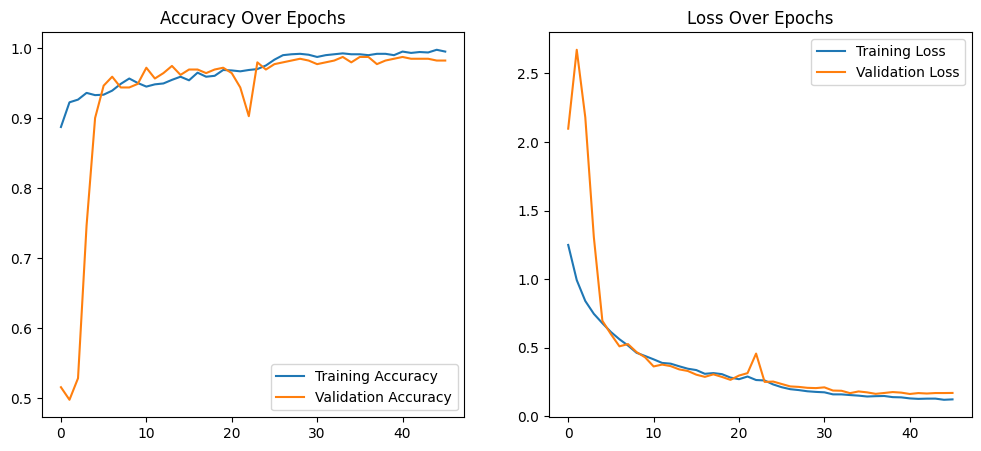

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.savefig(os.path.join(output_dir, 'training_history.png'))
plt.show()


Evaluating model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


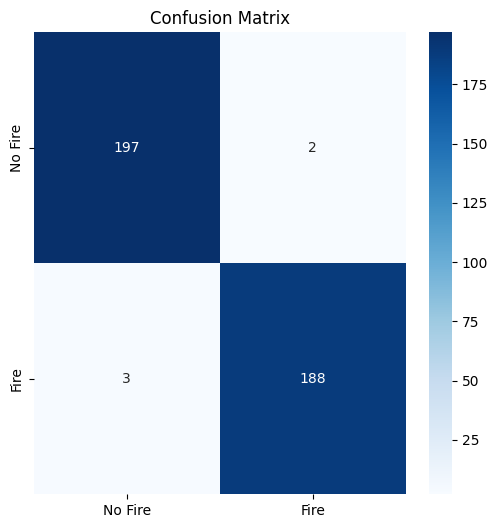


Classification Report:
              precision    recall  f1-score   support

     No Fire       0.98      0.99      0.99       199
        Fire       0.99      0.98      0.99       191

    accuracy                           0.99       390
   macro avg       0.99      0.99      0.99       390
weighted avg       0.99      0.99      0.99       390



In [45]:
print("\nEvaluating model...")
y_pred = (model.predict(X_val) > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fire', 'Fire'],
            yticklabels=['No Fire', 'Fire'])
plt.title('Confusion Matrix')
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['No Fire', 'Fire']))

In [46]:
print("\nConverting to TFLite...")


def representative_dataset():
    for i in range(100):
        yield [X_train[i:i+1].astype(np.float32)]


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset

tflite_model = converter.convert()


Converting to TFLite...
INFO:tensorflow:Assets written to: C:\Users\Aashish\AppData\Local\Temp\tmpsgj1ts2p\assets


INFO:tensorflow:Assets written to: C:\Users\Aashish\AppData\Local\Temp\tmpsgj1ts2p\assets


Saved artifact at 'C:\Users\Aashish\AppData\Local\Temp\tmpsgj1ts2p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2817150564496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817150561616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817202184720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817202191248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817150560272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817150558736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817202191824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817202192208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817202189904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2817202189712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  28

d:\Projects\Forest_Fire_Detection\myenv\Lib\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [47]:
tflite_path = os.path.join(output_dir, "fire_detection_tinyml.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f"\nModel size: {len(tflite_model)/1024:.2f} KB")
print(f"Training complete. All outputs saved to: {output_dir}")


Model size: 159.09 KB
Training complete. All outputs saved to: D:\Projects\Forest_Fire_Detection\training_output
